# Tree Census Final Project

## Packages

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, confusion_matrix, precision_recall_fscore_support, make_scorer, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')

## Preprocessing

In [2]:
# load in data with relative path
tree_df = pd.read_csv('sample_data/2015_Street_Tree_Census_-_Tree_Data.csv')

In [3]:
# drop columns that arent useful, or suffer from multicolinearity
tree_df = tree_df.drop(columns=[
    'borocode', 'x_sp', 'y_sp', 'state', 'nta_name', 'zip_city', 'address',
    'spc_latin', 'created_at', 'tree_id', 'block_id', 'user_type', 'bin',
    'bbl', 'council district', 'boro_ct', 'census tract', 'problems', 'status',
    'stump_diam', 'postcode', 'community board', 'cncldist', 'st_assem', 'st_senate', 
    'nta', 'spc_common'
])

In [4]:
# drop NA and dead tree values
tree_df = tree_df[tree_df['health'].notna()]
tree_df = tree_df.dropna(how='any')

In [5]:
# scale diameters (only continuos numerical feature left)
scaler = StandardScaler()
tree_df['tree_dbh'] = scaler.fit_transform(tree_df[['tree_dbh']])

In [6]:
# Ordinal Encode (categorical hierarchal features)
health = ['Poor', 'Fair', 'Good']
enc = OrdinalEncoder(categories=[health])
tree_df['health'] = enc.fit_transform(tree_df[['health']])

steward = ['None', '1or2', '3or4', '4orMore']
enc = OrdinalEncoder(categories=[steward])
tree_df['steward'] = enc.fit_transform(tree_df[['steward']])

sidewalk = ['NoDamage', 'Damage']
enc = OrdinalEncoder(categories=[sidewalk])
tree_df['sidewalk'] = enc.fit_transform(tree_df[['sidewalk']])

curbloc = ['OnCurb', 'OffsetFromCurb']
enc = OrdinalEncoder(categories=[curbloc])
tree_df['curb_loc'] = enc.fit_transform(tree_df[['curb_loc']])

yes_no = ['No', 'Yes']
enc = OrdinalEncoder(categories=[yes_no])

yes_no_features = [
    'brch_other', 'brch_shoe', 'brch_light', 'trnk_other', 'trnk_light',
    'trunk_wire', 'root_other', 'root_grate', 'root_stone'
]

for feat in yes_no_features:
    tree_df[feat] = enc.fit_transform(tree_df[[feat]])
    
# One Hot Encode (non-hierarchal categorical features)
enc = OneHotEncoder()
guards = enc.fit_transform(tree_df[['guards']])
tree_df['guards_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['guards'])

guards = enc.fit_transform(tree_df[['borough']])
tree_df['borough_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['borough'])

In [7]:
# split to x and y sets
y = np.asarray(tree_df['health'])
x = tree_df.drop(columns=['health'])

In [8]:
# random sample (stratified) for dev, test, train and val
x_dev, x_test, y_dev, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify = y)
x_train, x_val, y_train, y_val = train_test_split(x_dev, y_dev, test_size=0.2, random_state=42, stratify = y_dev)

In [9]:
# over-sampling of training data
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(x_train, y_train)

In [10]:
# under sampling of training data
rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(x_train, y_train)

In [11]:
# smote sampling of training data
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x_train, y_train)

## Decision Tree

Selected hyperparameters:  

max_depth: The maximum depth of the tree. 

min_samples_split: The minimum number of samples required to split an internal node. 

max_features: Number of features to consider when looking for the best split. 

Max_leaf_nodes: Maximum number of leaf nodes a decision tree can have. 

ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning


In [1]:
# function to evaluate the model
"""
  print decsion tree model result.
      Args:
          model: decision tree model
          X_train: training data of X.
          y_train: training data of y.
          X_test: testing data of X.   
          y_test: testing data of y.
      Returns:
          Print confusion matrix and classification report.
"""

def model_result(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    # confusion_matrix
    cf = confusion_matrix(y_test, model.predict(x_test))
    sns.heatmap(cf, annot = True, fmt = 'g')
    plt.show()
    # result plot
    print(classification_report(y_test, model.predict(x_test)))

In [2]:
# function to fit and tune the model
def dt_select(x_train,y_train,score):
    # possible values for the model to be tuned on
    param_grid = {
        'max_depth': [4,8,10,12,15,20],
        'min_samples_split': np.linspace(0.1, 0.3, 3, endpoint=True),
        "max_features":["log2","sqrt",None],
        "max_leaf_nodes": [None,10,20,30],
        'ccp_alpha' : np.logspace(-6, -4, 3)
    }
    
    # create a base model
    dt = DecisionTreeClassifier(random_state=100)

    # initantiate the random search model based on parameters defined above
    randomized_search = RandomizedSearchCV(estimator = dt, param_distributions = param_grid, scoring=score,cv=5,random_state=100)

    randomized_model=randomized_search.fit(x_train,y_train)
    return randomized_model

In [ ]:

#plot feature importance

def feature_importance(x_train, model):
  features = x_train.columns.values
  plt.figure(figsize = (12, 6))
  feat_imps = zip(features, model.best_estimator_.feature_importances_)
  feats,imps = zip(*(sorted(list(filter(lambda x: x[1] != 0 , feat_imps)), key=lambda x: x[1], reverse=True)))
  ax = sns.barplot(x = list(feats), y = list(imps))
  ax.tick_params(axis = 'x', rotation = 90)

## Decision Tree for random stratified sampling

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 1e-06}
optimal score 0.8109073571767318
test score 0.8109081987825261


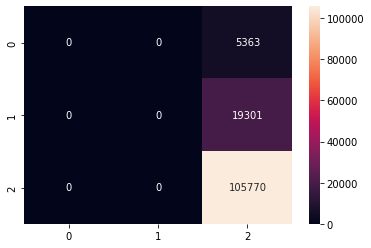

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.27      0.33      0.30    130434
weighted avg       0.66      0.81      0.73    130434



In [15]:

# accuracy as scoring metric
random_best = dt_select(x_train,y_train,'accuracy')
print("optimal hyperparameters",random_best.best_params_)
print("optimal score", random_best.best_score_)
print("test score",random_best.score(x_test,y_test))

#recall as metric for hyperparamter tuning
model_result(random_best, x_train, y_train, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 1e-06}
optimal score 0.3333333333333333
test score 0.3333333333333333


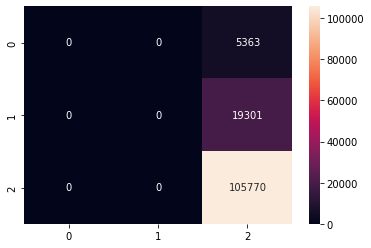

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.27      0.33      0.30    130434
weighted avg       0.66      0.81      0.73    130434



In [16]:
# random stratified sampling
# recall as scoring metric
random_best = dt_select(x_train,y_train,'recall_macro')
print("optimal hyperparameters",random_best.best_params_)
print("optimal score", random_best.best_score_)
print("test score",random_best.score(x_test,y_test))

#recall as metric for hyperparamter tuning
model_result(random_best, x_train, y_train, x_test, y_test)



optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 1e-06}
optimal f1 score 0.29852709065529426
test f1 score 0.2985272617454969


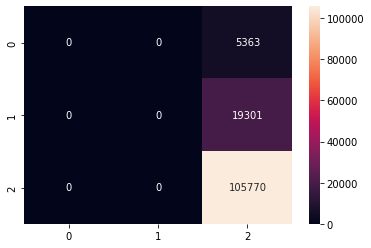

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.27      0.33      0.30    130434
weighted avg       0.66      0.81      0.73    130434



In [17]:
#f1 as scoring metric
random_best = dt_select(x_train,y_train,'f1_macro')
print("optimal hyperparameters",random_best.best_params_)
print("optimal f1 score", random_best.best_score_)
print("test f1 score",random_best.score(x_test,y_test))
#f1 as metric for hyperparamter tuning
model_result(random_best, x_train, y_train, x_test, y_test)

## Decision Tree for random over sampling

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal score 0.42521139435335636
test score 0.4216232268146592


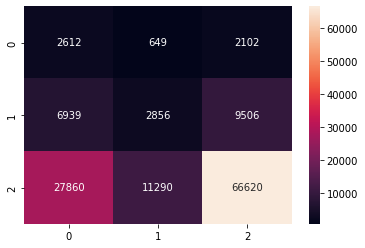

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.19      0.15      0.17     19301
         2.0       0.85      0.63      0.72    105770

    accuracy                           0.55    130434
   macro avg       0.37      0.42      0.34    130434
weighted avg       0.72      0.55      0.62    130434



In [18]:

# recall as scoring metric
over_best_recall = dt_select(x_ros, y_ros,'recall_macro')
print("optimal hyperparameters",over_best_recall.best_params_)
print("optimal score", over_best_recall.best_score_)
print("test score",over_best_recall.score(x_test,y_test))

# recallmacro as metric for hyperparamter tuning
model_result(over_best_recall, x_ros, y_ros, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal accuracy score 0.4252114213595847
test accuracy 0.552677982734563


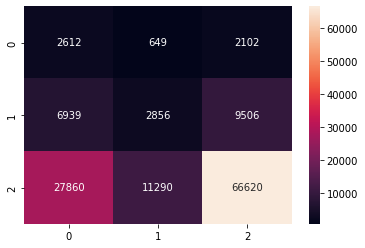

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.19      0.15      0.17     19301
         2.0       0.85      0.63      0.72    105770

    accuracy                           0.55    130434
   macro avg       0.37      0.42      0.34    130434
weighted avg       0.72      0.55      0.62    130434



In [19]:
# accuracy as score metric
over_best_acc = dt_select(x_ros, y_ros,'accuracy')
print("optimal hyperparameters",over_best_acc.best_params_)
print("optimal accuracy score", over_best_acc.best_score_)
print("test accuracy",over_best_acc.score(x_test,y_test))

# as metric for hyperparamter tuning
model_result(over_best_acc, x_ros, y_ros, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 1e-06}
optimal f1 score 0.40025096917702496
test f1 score 0.3201379887339995


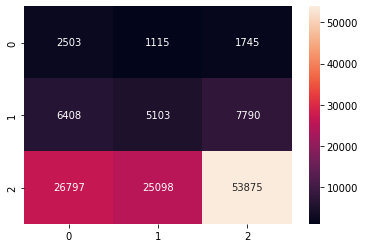

              precision    recall  f1-score   support

         0.0       0.07      0.47      0.12      5363
         1.0       0.16      0.26      0.20     19301
         2.0       0.85      0.51      0.64    105770

    accuracy                           0.47    130434
   macro avg       0.36      0.41      0.32    130434
weighted avg       0.72      0.47      0.55    130434



In [20]:
# f1 as score metric
over_best_f1 = dt_select(x_ros, y_ros,'f1_macro')
print("optimal hyperparameters",over_best_f1.best_params_)
print("optimal f1 score", over_best_f1.best_score_)
print("test f1 score",over_best_f1.score(x_test,y_test))

#f1 as metric for hyperparamter tuning
model_result(over_best_f1, x_ros, y_ros, x_test, y_test)

## Decision Tree for random under sampling

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal accuracy score 0.42282814886132025
test accuracy score 0.5130334115338026


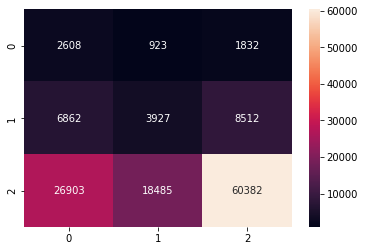

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.17      0.20      0.18     19301
         2.0       0.85      0.57      0.68    105770

    accuracy                           0.51    130434
   macro avg       0.36      0.42      0.33    130434
weighted avg       0.72      0.51      0.59    130434



In [21]:
# random under sampling
# accuracy as scoring metric

under_best_acc = dt_select(x_rus, y_rus,'accuracy')
print("optimal hyperparameters",under_best_acc.best_params_)
print("optimal accuracy score", under_best_acc.best_score_)
print("test accuracy score",under_best_acc.score(x_test,y_test))
# accuracy as metric for hyperparamter pruning
model_result(under_best_acc, x_rus, y_rus, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal recall score 0.4228293714894356
test recall score 0.4202120521676436


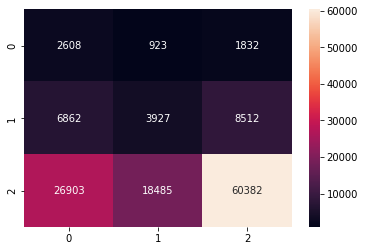

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.17      0.20      0.18     19301
         2.0       0.85      0.57      0.68    105770

    accuracy                           0.51    130434
   macro avg       0.36      0.42      0.33    130434
weighted avg       0.72      0.51      0.59    130434



In [22]:

# recall as scoring metric
under_best_recall = dt_select(x_rus, y_rus,'recall_macro')
print("optimal hyperparameters",under_best_recall.best_params_)
print("optimal recall score", under_best_recall.best_score_)
print("test recall score",under_best_recall.score(x_test,y_test))

# recall as metric for hyperparamter tuning
model_result(under_best_recall, x_rus, y_rus, x_test, y_test)



optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal f1 score 0.4097896911316369
test f1 score 0.3311391234276632


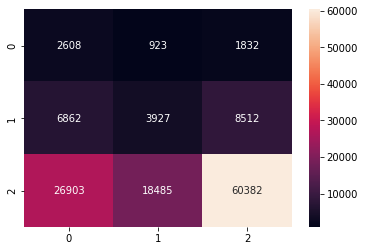

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.17      0.20      0.18     19301
         2.0       0.85      0.57      0.68    105770

    accuracy                           0.51    130434
   macro avg       0.36      0.42      0.33    130434
weighted avg       0.72      0.51      0.59    130434



In [24]:
# f1 as score metric
under_best_f1 = dt_select(x_rus, y_rus,'f1_macro')
print("optimal hyperparameters",under_best_f1.best_params_)
print("optimal f1 score", under_best_f1.best_score_)
print("test f1 score",under_best_f1.score(x_test,y_test))
# f1 as metric for hyperparamter pruning
model_result(under_best_f1, x_rus, y_rus, x_test, y_test)

## Decison Tree for smote sampling

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal recall score 0.42784390717769993
test recall score 0.41559624496818587


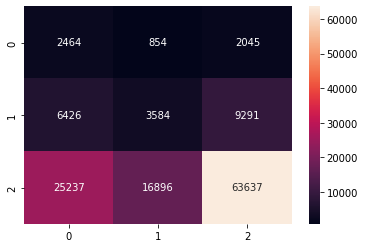

              precision    recall  f1-score   support

         0.0       0.07      0.46      0.12      5363
         1.0       0.17      0.19      0.18     19301
         2.0       0.85      0.60      0.70    105770

    accuracy                           0.53    130434
   macro avg       0.36      0.42      0.34    130434
weighted avg       0.72      0.53      0.60    130434



In [25]:

# recall as metric
smote_best = dt_select(x_smote, y_smote,"recall_macro")
print("optimal hyperparameters",smote_best.best_params_)
print("optimal recall score", smote_best.best_score_)
print("test recall score",smote_best.score(x_test,y_test))

#recall as metric for hyperparamter pruning
model_result(smote_best, x_smote, y_smote, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal score 0.427843910192804
test score 0.5342548721958998


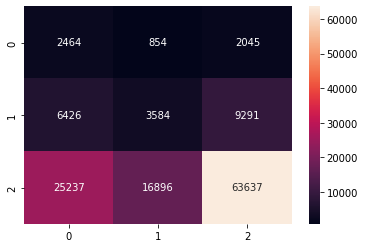

              precision    recall  f1-score   support

         0.0       0.07      0.46      0.12      5363
         1.0       0.17      0.19      0.18     19301
         2.0       0.85      0.60      0.70    105770

    accuracy                           0.53    130434
   macro avg       0.36      0.42      0.34    130434
weighted avg       0.72      0.53      0.60    130434



In [26]:
# accuracy as metric
smote_best_acc = dt_select(x_smote, y_smote,"accuracy")
print("optimal hyperparameters",smote_best_acc.best_params_)
print("optimal score", smote_best_acc.best_score_)
print("test score",smote_best_acc.score(x_test,y_test))

#accuracy as metric for hyperparamter pruning
model_result(smote_best_acc, x_smote, y_smote, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal f1 score 0.4084079737595042
test f1 score 0.33512061923807873


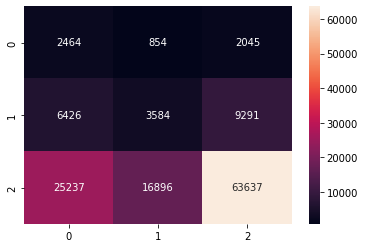

              precision    recall  f1-score   support

         0.0       0.07      0.46      0.12      5363
         1.0       0.17      0.19      0.18     19301
         2.0       0.85      0.60      0.70    105770

    accuracy                           0.53    130434
   macro avg       0.36      0.42      0.34    130434
weighted avg       0.72      0.53      0.60    130434



In [27]:
# f1 sccore as metric
smote_best_f1 = dt_select(x_smote, y_smote,'f1_macro')
print("optimal hyperparameters",smote_best_f1.best_params_)
print("optimal f1 score", smote_best_f1.best_score_)
print("test f1 score",smote_best_f1.score(x_test,y_test))
# f1 as metric for hyperparamter pruning
model_result(smote_best_f1, x_smote, y_smote, x_test, y_test)



overall, recall as a scoring metric for tunning is best for predicting bad and fair trees well.

under sampling is best in having highest recall in poor and fair trees, which means have highest rate in predicting correct poor and fair trees.

## Decision tree: feature importance

print feature importance plot for the best model: under sampling method

optimal hyperparameters: {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}

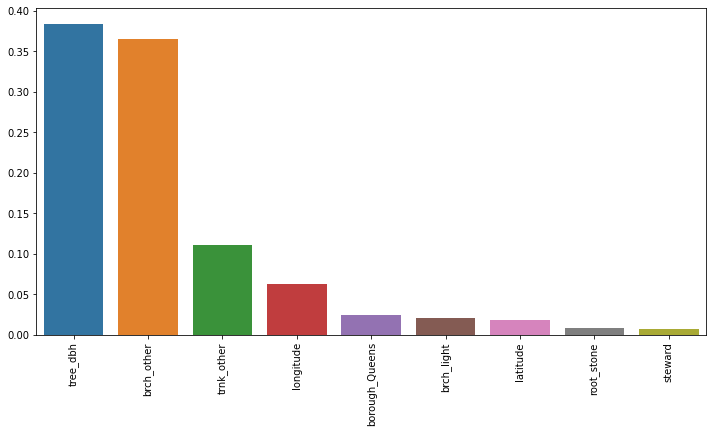

In [48]:
feature_importance(x_rus, under_best_recall)

# SVM

In [29]:
## svm model


"""
A short cut to print the svm model result.
    Args:
        svm: the svm model.
        X_train: training data of X.
        y_train: training data of y.
        X_test: testing data of X.   
        y_test: testing data of y.
        report_test: boolean; print the classification report of testing data if true, default as True.
        report_train: boolean; print the classification report of training data if true, default as False.
        cf: boolean; print the confusion matrix if true, default as False.
    Returns:
        Print the training and the testing accuracy.
        Return the classification report if report = True.
        Return the confusion matrix if report = True.
"""
def SVM_result(svm, X_train, y_train, X_test, y_test, report_test = True, report_train = False, cf = False):
    # fit the model
    svm.fit(X_train, y_train)
    # predict y
    y_train_predict = svm.predict(X_train)
    y_test_predict = svm.predict(X_test)    
    # show result report on testing data
    if (report_test):
        print("Result on test data:")
        print(classification_report(y_test, y_test_predict))
    # show result report on training data
    if (report_train):
        print("Result on training data:")
        print(classification_report(y_train, y_train_predict))
    # show confusion_matrix
    if (cf):
        cf = confusion_matrix(y_test, y_test_predict)
        sns.heatmap(cf, annot = True, fmt = 'g')

In [30]:
#Modeling and hyperparameter tuning for different sampling

# Basic SVM models
warnings.filterwarnings('ignore')
# primal svm (for large data set) before hyperparameter tuning
svm = LinearSVC(tol=0.0001, dual = False, random_state = 2022) 
# random search for hyperparameter tuning
param_list = {'C': stats.uniform(0, 5), 
              'loss': ['hinge', 'squared_hinge']} # random list for hyperparameter tuning 
rand_search_ac = RandomizedSearchCV(svm, 
                                    param_distributions = param_list, 
                                    cv = 5,
                                    scoring = 'accuracy',
                                    random_state = 2022) 

rand_search_f1 = RandomizedSearchCV(svm, 
                                    param_distributions = param_list, 
                                    cv = 5,
                                    scoring = 'f1_macro',
                                    random_state = 2022) 

rand_search_recall = RandomizedSearchCV(svm, 
                                        param_distributions = param_list, 
                                        cv = 5,
                                        scoring = 'recall_macro',
                                        random_state = 2022) 

## SVM for random stratified sampling

In [32]:

# Hyperparameter tuning random Sampling

# accuracy as scoring metric
rand_search_ac.fit(x_train, y_train)
print(f"Best parameters for tuning on accuray: {rand_search_ac.best_params_}")
SVM_result(rand_search_ac.best_estimator_, x_train, y_train, x_test, y_test)

# f1 as scoring metric
rand_search_f1.fit(x_train, y_train) 
print(f"Best parameters for tuning on f1: {rand_search_f1.best_params_}")
SVM_result(rand_search_f1.best_estimator_, x_train, y_train, x_test, y_test)

# macro-recall as scoring metric
rand_search_recall.fit(x_train, y_train) 
print(f"Best parameters for tuning on macro recall: {rand_search_recall.best_params_}")
SVM_result(rand_search_recall.best_estimator_, x_train, y_train, x_test, y_test)

Best parameters for tuning on accuray: {'C': 2.5660378900685785, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.35      0.01      0.02     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.39      0.34      0.31    130434
weighted avg       0.71      0.81      0.73    130434

Best parameters for tuning on f1: {'C': 2.5660378900685785, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.35      0.01      0.02     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.39      0.34      0.31    130434
weighted avg       0.71      0.81      0.73    130434

Best parameters for t

## SVM for random under sampling

In [33]:
# Hyperparameter tuning under sampling

# accuracy as scoring metric
rand_search_ac.fit(x_rus, y_rus)
print(f"Best parameters for tuning on accuray: {rand_search_ac.best_params_}")
SVM_result(rand_search_ac.best_estimator_, x_rus, y_rus, x_test, y_test)

# f1 as scoring metric
rand_search_f1.fit(x_rus, y_rus) 
print(f"Best parameters for tuning on f1: {rand_search_f1.best_params_}")
SVM_result(rand_search_f1.best_estimator_, x_rus, y_rus, x_test, y_test)

# macro-recall as scoring metric
rand_search_recall.fit(x_rus, y_rus) 
print(f"Best parameters for tuning on macro recall: {rand_search_recall.best_params_}")
SVM_result(rand_search_recall.best_estimator_, x_rus, y_rus, x_test, y_test)


Best parameters for tuning on accuray: {'C': 0.04679306903882352, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.07      0.53      0.12      5363
         1.0       0.18      0.16      0.17     19301
         2.0       0.85      0.56      0.68    105770

    accuracy                           0.50    130434
   macro avg       0.36      0.42      0.32    130434
weighted avg       0.72      0.50      0.58    130434

Best parameters for tuning on f1: {'C': 0.04679306903882352, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.07      0.53      0.12      5363
         1.0       0.18      0.16      0.17     19301
         2.0       0.85      0.56      0.68    105770

    accuracy                           0.50    130434
   macro avg       0.36      0.42      0.32    130434
weighted avg       0.72      0.50      0.58    130434

Best parameters for

## SVM for random over sampling

In [34]:
# Hyperparameter tuning over sampling

# accuracy as scoring metric
rand_search_ac.fit(x_ros, y_ros)
print(f"Best parameters for tuning on accuray: {rand_search_ac.best_params_}")
SVM_result(rand_search_ac.best_estimator_, x_ros, y_ros, x_test, y_test)

# f1 as scoring metric
rand_search_f1.fit(x_ros, y_ros) 
print(f"Best parameters for tuning on f1: {rand_search_f1.best_params_}")
SVM_result(rand_search_f1.best_estimator_, x_ros, y_ros, x_test, y_test)

# macro-recall as scoring metric
rand_search_recall.fit(x_ros, y_ros) 
print(f"Best parameters for tuning on macro recall: {rand_search_recall.best_params_}")
SVM_result(rand_search_recall.best_estimator_, x_ros, y_ros, x_test, y_test)

Best parameters for tuning on accuray: {'C': 4.620282385385153, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.07      0.53      0.12      5363
         1.0       0.18      0.15      0.16     19301
         2.0       0.85      0.57      0.68    105770

    accuracy                           0.51    130434
   macro avg       0.37      0.42      0.32    130434
weighted avg       0.72      0.51      0.58    130434

Best parameters for tuning on f1: {'C': 0.04679306903882352, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.07      0.53      0.12      5363
         1.0       0.18      0.15      0.16     19301
         2.0       0.85      0.57      0.68    105770

    accuracy                           0.51    130434
   macro avg       0.37      0.42      0.32    130434
weighted avg       0.72      0.51      0.58    130434

Best parameters for t

## SVM for smote sampling

In [35]:
# Hyperparameter tuning after smote sampling

# accuracy as scoring metric
rand_search_ac.fit(x_smote, y_smote)
print(f"Best parameters for tuning on accuray: {rand_search_ac.best_params_}")
SVM_result(rand_search_ac.best_estimator_, x_smote, y_smote, x_test, y_test)

# f1 as scoring metric
rand_search_f1.fit(x_smote, y_smote) 
print(f"Best parameters for tuning on f1: {rand_search_f1.best_params_}")
SVM_result(rand_search_f1.best_estimator_, x_smote, y_smote, x_test, y_test)

# macro-recall as scoring metric
rand_search_recall.fit(x_smote, y_smote) 
print(f"Best parameters for tuning on macro recall: {rand_search_recall.best_params_}")
SVM_result(rand_search_recall.best_estimator_, x_smote, y_smote, x_test, y_test)

Best parameters for tuning on accuray: {'C': 2.5660378900685785, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.06      0.54      0.12      5363
         1.0       0.18      0.16      0.17     19301
         2.0       0.85      0.56      0.67    105770

    accuracy                           0.50    130434
   macro avg       0.37      0.42      0.32    130434
weighted avg       0.72      0.50      0.58    130434

Best parameters for tuning on f1: {'C': 2.5660378900685785, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.06      0.54      0.12      5363
         1.0       0.18      0.16      0.17     19301
         2.0       0.85      0.56      0.67    105770

    accuracy                           0.50    130434
   macro avg       0.37      0.42      0.32    130434
weighted avg       0.72      0.50      0.58    130434

Best parameters for t

# Logistic Regression Model

Motivation: The main reason I want to use logistic regression model with multiple classes is to set a reference for all other more complicated models to better evaluate their performances as logistic regression is the simplest one.

Metrics: Average Recall

Hyperparameters tuning: penalty: l1, l2, elasticnet (solver = saga)

class_weight: balanced or default

multi_class: multinomial (solver = saga), ovr (solver = liblinear)

l1_ratio: 0.2, 0.4, 0.6, 0.8

In [36]:
# Hyperparameters
penalty = ['l1', 'l2', 'elasticnet']
class_weight = ['balanced','']
multi_class = ['multinomial', 'ovr']
l1_ratio = [0.2, 0.4, 0.6, 0.8]



In [37]:
# function to fit and tune the model using simple grid search
def logReg(x_train, y_train, x_val, y_val, penalty, weight, multi, l1_ratio):

    target_names = ['Poor', 'Fair', 'Good']
    report = {}

    # when multi_class == 'ovr', the solver must be liblinear.
    # liblinear only support l1 and l2 penalty, and l1 doesn't work on my laptop
    model = LogisticRegression(penalty='l2', class_weight='balanced', multi_class=multi[1], solver='liblinear')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    report["l2, balanced, ovr"] = classification_report(y_val, y_pred, target_names=target_names, output_dict=True)

    model = LogisticRegression(penalty='l2', class_weight='', multi_class=multi[1], solver='liblinear')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    report["l2, , ovr"] = classification_report(y_val, y_pred, target_names=target_names, output_dict=True)

    for i in penalty:
        for j in weight:
            tracker = 0
            if i != 'elasticnet':
                model = LogisticRegression(penalty=i, class_weight=j, multi_class=multi[0], solver='saga')
            else:
                while tracker != len(l1_ratio):
                    model = LogisticRegression(penalty=i, class_weight=j, multi_class=multi[0], solver='saga',l1_ratio=l1_ratio[tracker])
                    model.fit(x_train, y_train)
                    y_pred = model.predict(x_val)
                    label = i + ", " + j + ", multinomial, " + str(l1_ratio[tracker])
                    report[label] = classification_report(y_val, y_pred, target_names=target_names, output_dict=True)
                    tracker += 1
                continue

            model.fit(x_train, y_train)
            y_pred = model.predict(x_val)
            label = i + ", " + j + ", multinomial"
            report[label] = classification_report(y_val, y_pred, target_names=target_names, output_dict=True)

    return report

In [38]:
# function to evaluate the model
def model_result(report):
    best_recall = 0
    best_accuracy = 0
    best_f1_score = 0
    for params, metrics in report.items():
        # weighted recall on validation set
        avg_recall = metrics['macro avg']['recall']
        # accuracy on validation set
        accuracy = metrics['accuracy']
        # f1 score on validation set
        f1_score = metrics['macro avg']['f1-score']
        
        if best_recall < avg_recall:
            best_recall = avg_recall
            best_params_recall = params
        if best_accuracy < accuracy:
            best_accuracy = accuracy
            best_params_accuracy = params
        if best_f1_score < f1_score:
            best_f1_score = f1_score
            best_params_f1_score = params
        
    
    print("Accuracy as metric for hyperparamter tuning:")
    print("Optimal Hyperparameters: ", best_params_accuracy)
    print("Optimal accuracy score: ", best_accuracy)
    
    print()
    print("F1 score as metric for hyperparamter tuning:")
    print("Optimal Hyperparameters: ", best_params_f1_score)
    print("Optimal F1 score: ", best_f1_score)

    print()
    print("Macro recall as metric for hyperparamter tuning:")
    print("Optimal Hyperparameters: ", best_params_recall)
    print("Optimal macro recall score: ", best_recall)

## LR for random stratified sampling

In [43]:
# random stratified sampling
report_random = logReg(x_train, y_train, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)
# evaluate the model
model_result(report_random)
# recall score on test set using best_recall_params
model = LogisticRegression(penalty='elasticnet', class_weight='balanced', multi_class='multinomial', l1_ratio = 0.8, solver='saga')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
test_score = recall_score(y_test, y_pred, average='macro')
print("Average recall on test dataset: ", test_score)

Accuracy as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, , ovr
Optimal accuracy score:  0.8110265649557251

F1 score as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal F1 score:  0.36378365483866054

Macro recall as metric for hyperparamter tuning:
Optimal Hyperparameters:  elasticnet, balanced, multinomial, 0.2
Optimal macro recall score:  0.4108781996224646
Average recall on test dataset:  0.34166908040476374


## LR for random over sampling

In [44]:

# Over sampling
report_ros = logReg(x_ros, y_ros, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)
# evaluate the model
model_result(report_ros)
# recall score on test set using best_recall_params
model = LogisticRegression(penalty='l1', class_weight='balanced', multi_class='multinomial', solver='saga')
model.fit(x_ros, y_ros)
y_pred = model.predict(x_test)
test_score = recall_score(y_test, y_pred, average='macro')
print("Average recall on test dataset: ", test_score)

Accuracy as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal accuracy score:  0.504523325794457

F1 score as metric for hyperparamter tuning:
Optimal Hyperparameters:  l1, balanced, multinomial
Optimal F1 score:  0.3241342334017288

Macro recall as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal macro recall score:  0.42314407353638056
Average recall on test dataset:  0.4194198721041554


## LR for random under sampling

In [45]:
# Under sampling
report_rus = logReg(x_rus, y_rus, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)
# evaluate the model
model_result(report_rus)
# recall score on test set using best_recall_params
model = LogisticRegression(penalty='l2', class_weight='balanced', multi_class='ovr', solver='liblinear')
model.fit(x_ros, y_ros)
y_pred = model.predict(x_test)
test_score = recall_score(y_test, y_pred, average='macro')
print("Average recall on test dataset: ", test_score)


Accuracy as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal accuracy score:  0.499444167593054

F1 score as metric for hyperparamter tuning:
Optimal Hyperparameters:  l1, balanced, multinomial
Optimal F1 score:  0.3222617798591999

Macro recall as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal macro recall score:  0.42266914209907175
Average recall on test dataset:  0.41878882584060256


## LR for smote sampling

In [46]:
## SMOTE on train data
report_smote = logReg(x_ros, y_ros, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)
# evaluate the model
model_result(report_smote)
# recall score on test set using best_recall_params
model = LogisticRegression(penalty='l1', class_weight='balanced', multi_class='multinomial', solver='saga')
model.fit(x_smote, y_smote)
y_pred = model.predict(x_test)
test_score = recall_score(y_test, y_pred, average='macro')
print("Average recall on test dataset: ", test_score)

Accuracy as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal accuracy score:  0.504523325794457

F1 score as metric for hyperparamter tuning:
Optimal Hyperparameters:  l1, balanced, multinomial
Optimal F1 score:  0.3241342334017288

Macro recall as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal macro recall score:  0.42314407353638056
Average recall on test dataset:  0.41976722060899146


##  LR: Features importance analysis

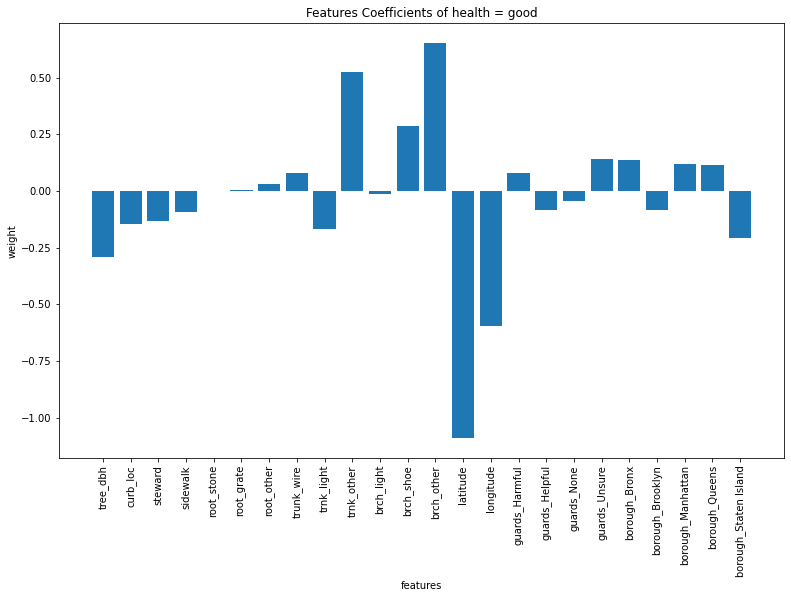

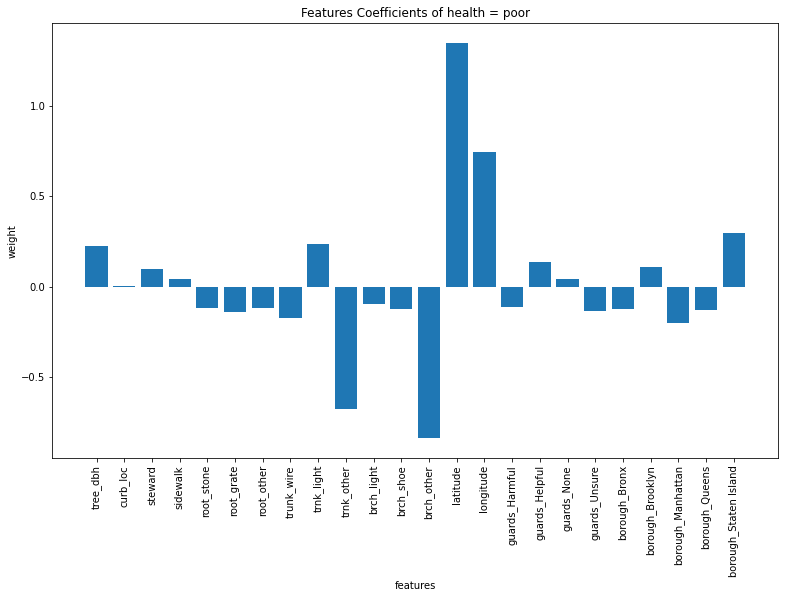

In [47]:
# Features importance analysis
# Best Model is using SMOTE sampling
# Features Coefficients of health = good
plt.figure(figsize=(13, 8))
plt.bar(x= x_train.columns, height=model.coef_[0])
plt.title("Features Coefficients of health = good")
plt.xlabel('features')
plt.xticks(rotation=90)
plt.ylabel('weight')
plt.show()

# Features Coefficients of health = poor
plt.figure(figsize=(13, 8))
plt.bar(x= x_train.columns, height=model.coef_[2])
plt.title("Features Coefficients of health = poor")
plt.xlabel('features')
plt.xticks(rotation=90)
plt.ylabel('weight')
plt.show()